# Section 5.2: Linear ODE system with two unknown parameters

This notebook reproduces the analyses in Section 5.2 of the manuscript, including Figure 4. 

## Setup 

We load the Julia environment specified in the `Project.toml` and `Manifest.toml` files: First, we activate this environment, then install all dependencies (if some packages are not yet installed), and print out which packages and versions are currently in our environment: 

In [1]:
using Pkg;

# all paths are relative to the `notebook` subfolder main folder, i.e., assuming `pwd()` outputs
# ".../DeepDynamicodelingWithJust2TimePoints/notebooks"

Pkg.activate("../.")
Pkg.instantiate()
Pkg.status()

  Activating environment at `~/Desktop/DeepDynamicModelingWithJust2TimePoints/Project.toml`


      Status `~/Desktop/DeepDynamicModelingWithJust2TimePoints/Project.toml`
  [6e4b80f9] BenchmarkTools v1.2.1
  [336ed68f] CSV v0.9.10
  [a93c6f00] DataFrames v1.2.2
  [aae7a2af] DiffEqFlux v1.44.0
  [31c24e10] Distributions v0.25.24
  [587475ba] Flux v0.12.8
  [033835bb] JLD2 v0.4.15
  [b964fa9f] LaTeXStrings v1.3.0
  [1dea7af3] OrdinaryDiffEq v5.65.5
  [91a5bcdd] Plots v1.23.5
  [112f6efa] VegaLite v2.6.0
  [9a3f8284] Random


Next, we load and precompile the necessary packages (in the versions specified by the `*.toml` files). 

In [2]:
using Distributions
using Random
using Flux
using DiffEqFlux
using OrdinaryDiffEq
using Plots 
using LaTeXStrings
gr()

Plots.GRBackend()

Additionally, we import some user-defined functions, with different files for separate functionality.

In [3]:
include("../src/simulation.jl") # for simulating data
include("../src/model.jl") # for initializing and training the model
include("../src/plotting.jl") # for plotting data and learned trajectories

plot_batch_solution (generic function with 1 method)

## Data generation

First, we define the ground-truth developments as solutions of the underlying two-dimensional linear ODE system with two distinct sets of parameters, corresponding to two groups of individuals with two distinct underlying development patterns. 

In [4]:
# define initial condition
true_u0 = Float32[2, 1]
# define time span on which to solve the ODE
tspan = (0.0f0, 10.0f0)
# define parameters for the two distinct groups
true_odeparams_group1 = Float32[-0.2, 0.00, 0.00, -0.2]
true_odeparams_group2 = Float32[-0.2, 0.00, 0.00, 0.2]
  
# define corresponding ODE problems for the two groups
prob1 = ODEProblem(linear_2d_system,true_u0,tspan,true_odeparams_group1)
prob2 = ODEProblem(linear_2d_system,true_u0,tspan,true_odeparams_group2)
  
# solve ODE systems to obtain "true" underlying trajectory in each group
dt=0.1
sol_group1 = solve(prob1, Tsit5(), saveat = dt);
sol_group2 = solve(prob2, Tsit5(), saveat = dt);

Now, we simulate data of `n` individuals by adding noise to the true development patterns:

First, we randomly assign each individual into one of two groups, corresponding to the two distinct development patterns `sol_group1` and `sol_group2` created above. 

Next, for each simulated individual, we randomly draw a second measurement time point (or several subsequent random measurement time points) between `t_start`(here: $1.5$) and `t_end` (here: $10$) (here, `t_start`, `t_end`  $\in$ `tspan` is necessary). 

Then, for each individual, we simulate `p`$/2=5$ measurements of each dimension of the ODE solution, i.e., for a 2-dimensional ODE system as in this example, we have $2*$ `p`$=10$ variables. We do this by adding a variable-specific and an individual-specific measurement error to the true ODE solution of the individual's group at the individual-specific second measurement time point. These errors are drawn from to $\mathcal{N}(0,\sigma_{\mathrm{var}})$ and $\mathcal{N}(0,\sigma_{\mathrm{ind}})$, respectively.

The simulation design also allows for generating data at more than two time points, which can be set with the `maxntps` option specifying the maximum number of timepoints after the baseline visit. If `maxntps`$>1$, for each individual, a random number of time points between $1$ and `maxntps` is drawn, corresponding to the number of measurement time point available for that individual. 

In our current setting, we set $\sigma_{\mathrm{ind}} = \sigma_{\mathrm{var}} = 0.1$. 

In [5]:
# define numbers of individuals and variables 
n = 100 
p = 10
q, q_info = 50, 10

# set seed for reproducibility
Random.seed!(12);

# generate time dependent variables
xs, tvals, group1, group2 = generate_xs(n, p, true_u0, sol_group1, sol_group2, maxntps=1, σ_var=0.1, σ_ind=0.1); # default vals: t_start=1.5, t_end=10, maxntps=10, dt=0.1, σ_var=0.1, σ_ind=0.5
# generate baseline variables
x_baseline = generate_baseline(n, q, q_info, group1,  σ_info=0.5, σ_noise=0.5); # default vals: σ_info=1, σ_noise=1

We can now look at the data we generated (dots) and the true trajectories (solid lines): The plot shows the true ODE solutions as lines in the first row and the solutions and drawn measurements as dots in the second row, separately for each group (=column).

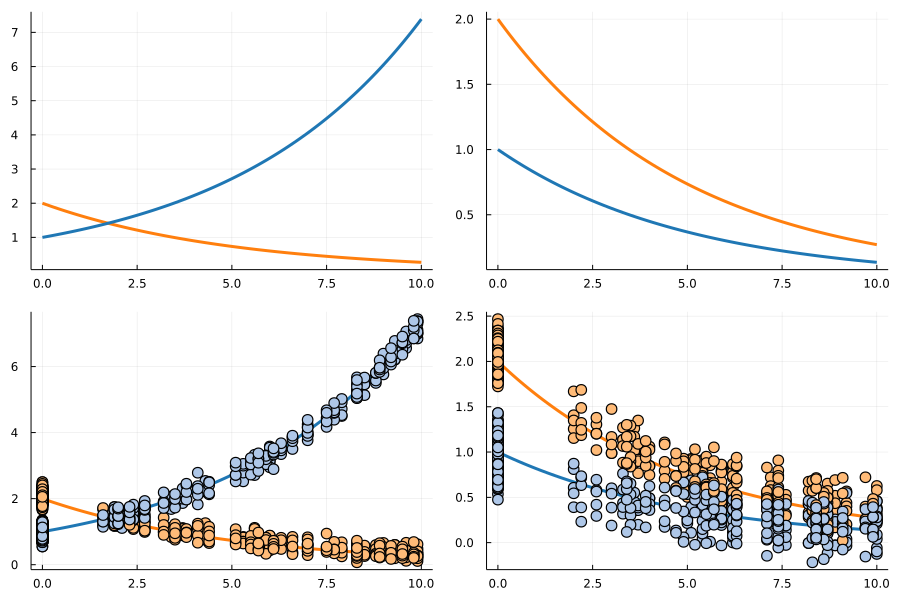

In [6]:
# look at data: 
data = simdata(xs, x_baseline, tvals, group1, group2);

plot(plot_truesolution(2, data, sol_group1, sol_group2, showdata=false), 
    plot_truesolution(1,  data, sol_group1, sol_group2, showdata=false), 
    plot_truesolution(2, data, sol_group1, sol_group2, showdata=true), 
    plot_truesolution(1,  data, sol_group1, sol_group2, showdata=true),
    layout = (2,2),
    legend = false,
    size=(900,600)
)

## Define and train model 

Next, we define the architecture of our model and initialize the model (with random weights). 

In [7]:
zdim = nODEparams = 2
m = init_vae(p, q, zdim, nODEparams, prob1);

We specify the model loss, the optimizer and the learning rate for the stochastic gradient descent:

In [8]:
L = loss_wrapper(m)
ps = getparams(m)
opt = ADAM(0.0005)

ADAM(0.0005, (0.9, 0.999), IdDict{Any, Any}())

Finally, we define the training data for the model and define two callback functions: One to show the mean of the loss function across the dataset after each training epoch (to verify that it decreases), and one to plot the currently learned data encoding and trajectories from four exemplary individuals. 

In [9]:
trainingdata = zip(xs, x_baseline, tvals);
evalcb() = @show(mean(L.(xs, x_baseline, tvals)))
evalcb_zs() = eval_z_trajectories(xs, x_baseline, tvals, group1, sol_group1, sol_group2, m, dt, swapcolorcoding=true)

evalcb_zs (generic function with 1 method)

Now, it's time to start training!

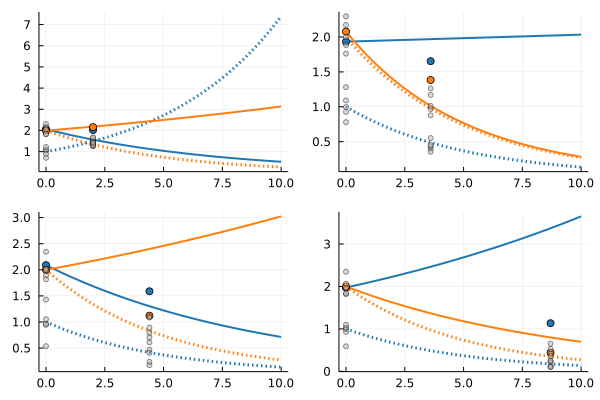

mean(L.(xs, x_baseline, tvals)) = 63.89063303267368
mean(L.(xs, x_baseline, tvals)) = 

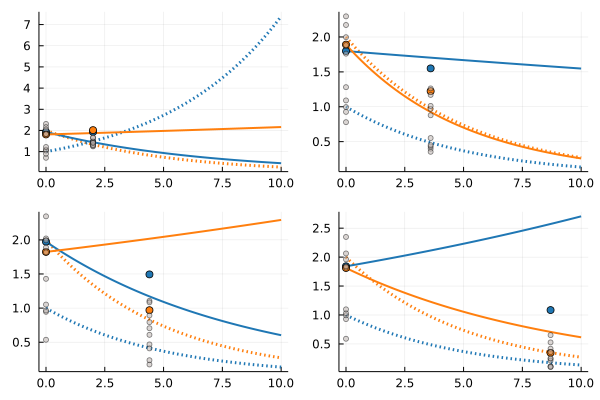

51.44026130088385


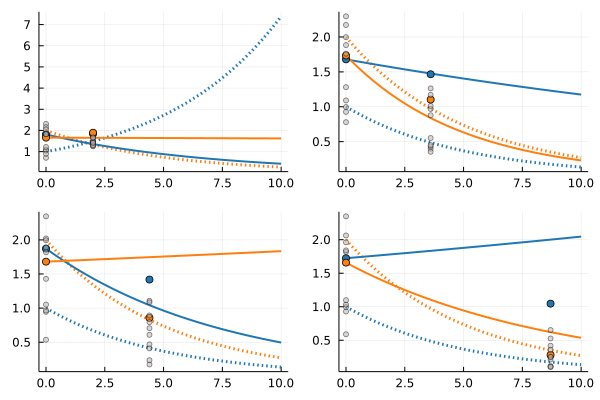

mean(L.(xs, x_baseline, tvals)) = 45.26637752434578
mean(L.(xs, x_baseline, tvals)) = 

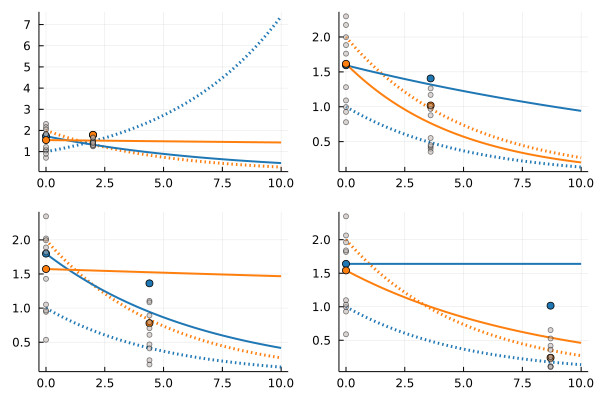

42.667119403463495


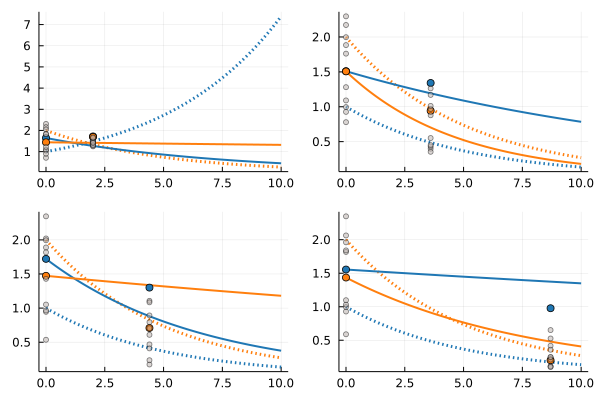

mean(L.(xs, x_baseline, tvals)) = 39.05609084645115
mean(L.(xs, x_baseline, tvals)) = 

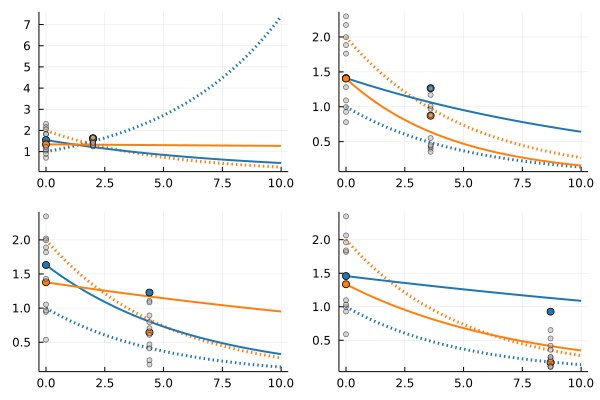

37.90805695736028


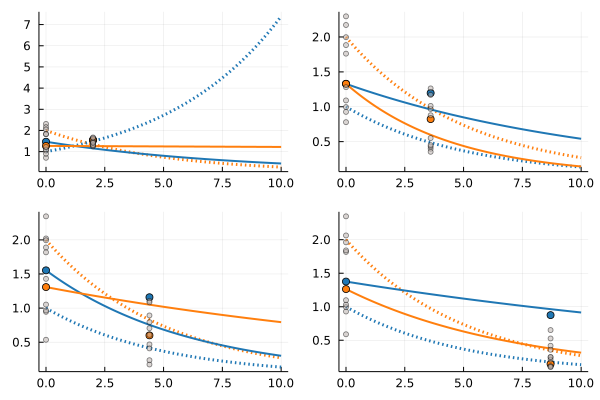

mean(L.(xs, x_baseline, tvals)) = 35.45543420383167
mean(L.(xs, x_baseline, tvals)) = 

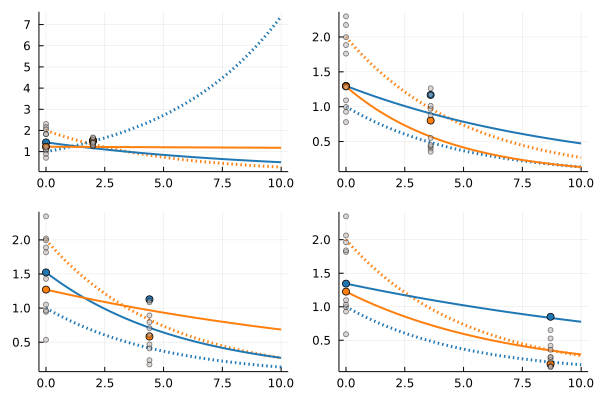

35.85163465347435


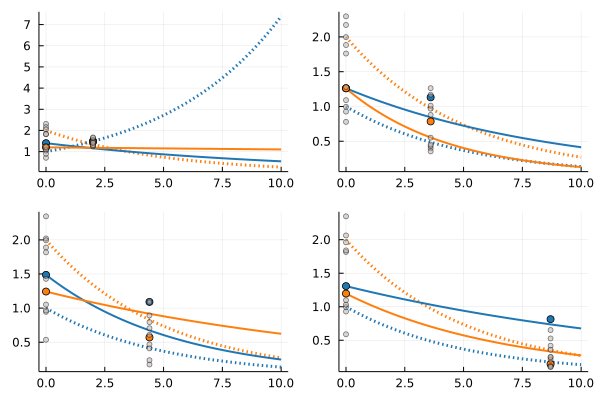

mean(L.(xs, x_baseline, tvals)) = 34.37337875798146
mean(L.(xs, x_baseline, tvals)) = 

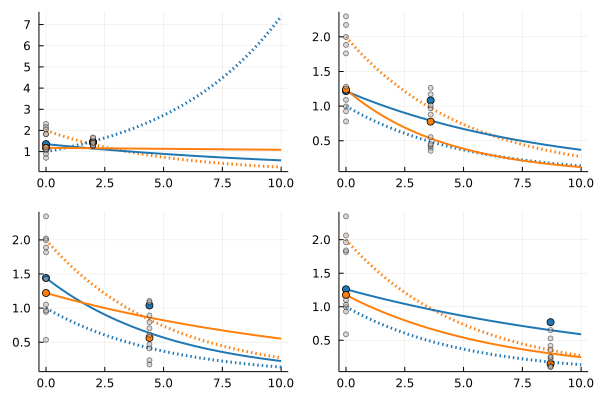

33.45021670061609


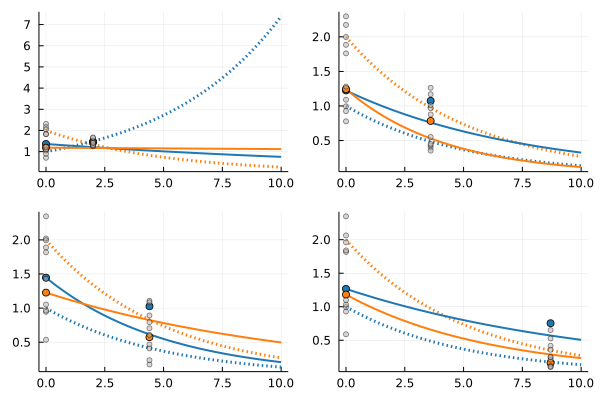

mean(L.(xs, x_baseline, tvals)) = 32.58814458031282
mean(L.(xs, x_baseline, tvals)) = 

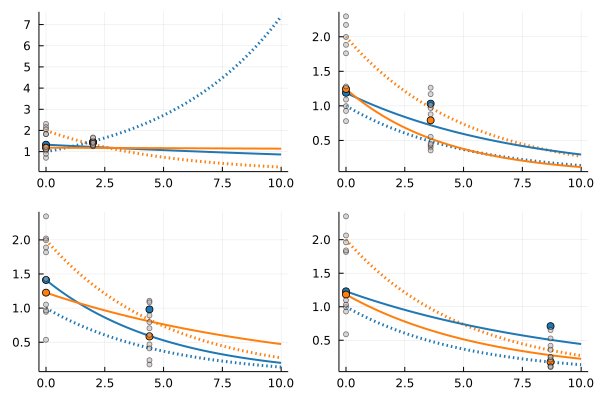

32.00005739210605


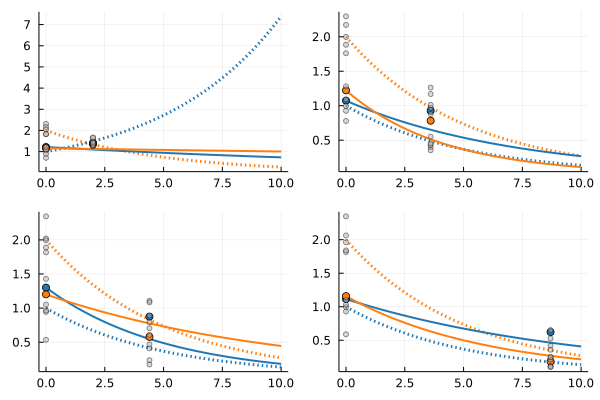

mean(L.(xs, x_baseline, tvals)) = 31.692135418967496
mean(L.(xs, x_baseline, tvals)) = 

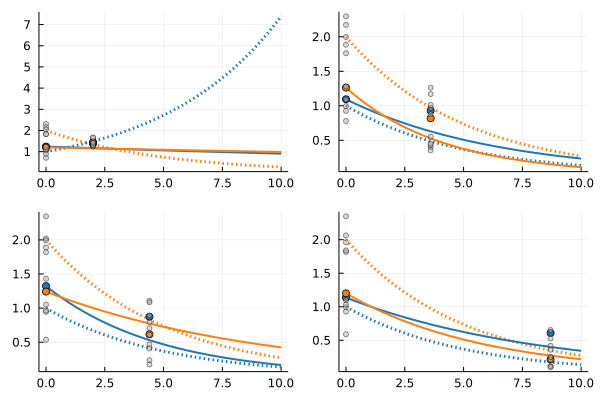

31.738360519077283


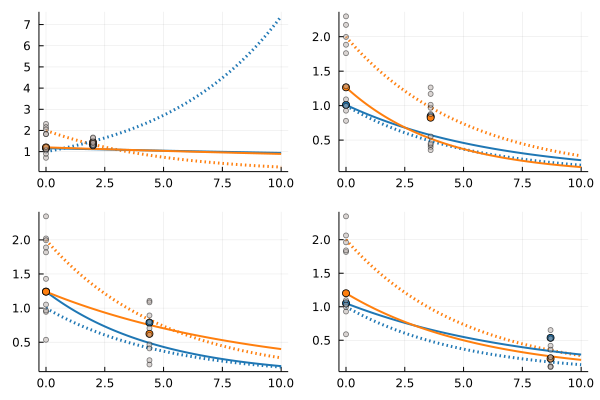

mean(L.(xs, x_baseline, tvals)) = 30.465513786556453
mean(L.(xs, x_baseline, tvals)) = 

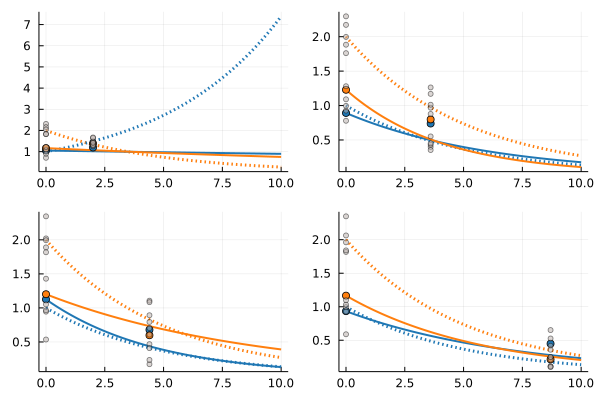

30.305686007502757


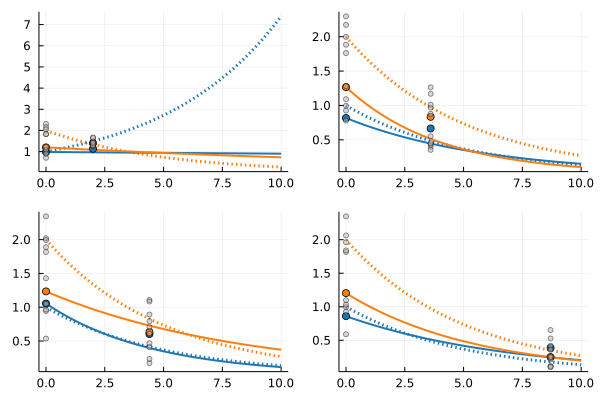

mean(L.(xs, x_baseline, tvals)) = 29.56512309634202
mean(L.(xs, x_baseline, tvals)) = 

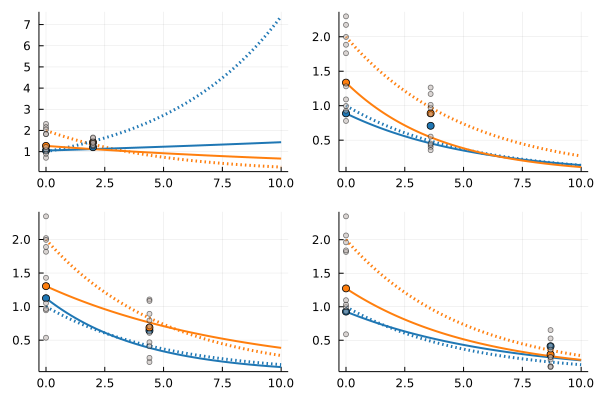

29.568028441830066


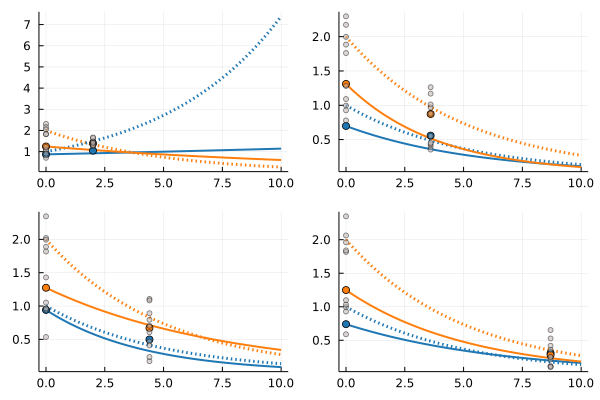

mean(L.(xs, x_baseline, tvals)) = 28.325877439098793
mean(L.(xs, x_baseline, tvals)) = 

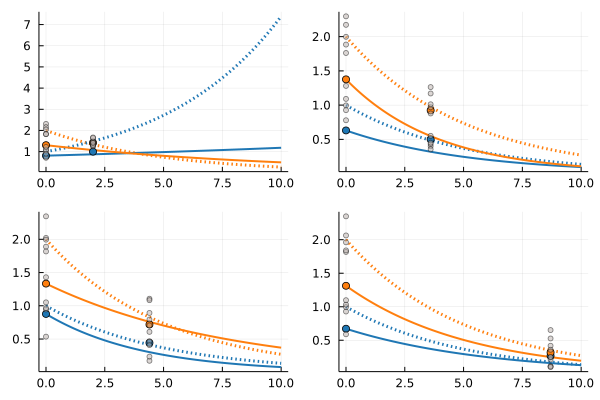

28.340183744788774


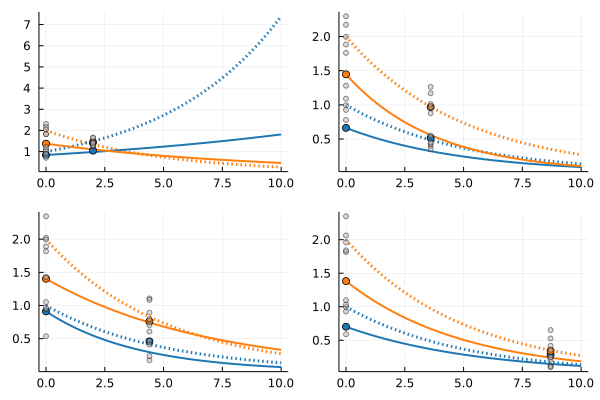

mean(L.(xs, x_baseline, tvals)) = 27.37214196104379
mean(L.(xs, x_baseline, tvals)) = 

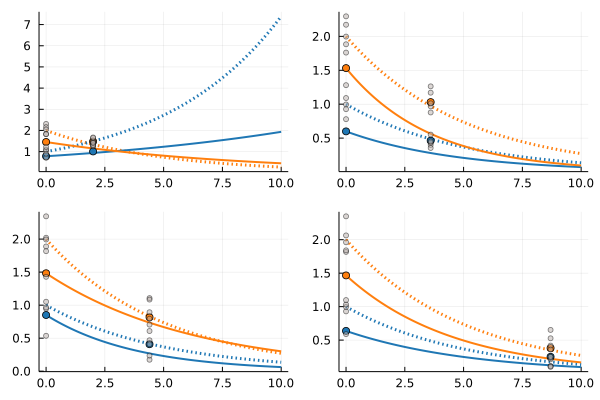

26.604371684146663


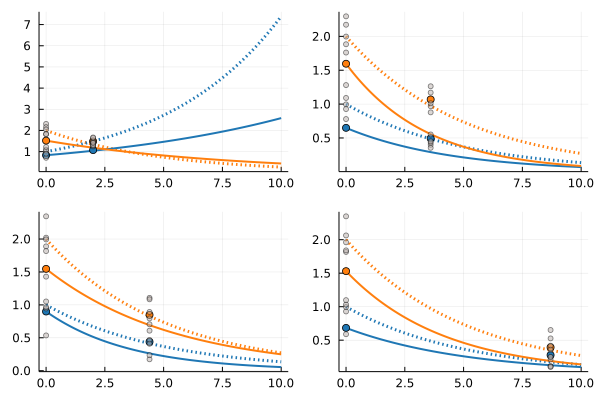

mean(L.(xs, x_baseline, tvals)) = 25.81566920676096
mean(L.(xs, x_baseline, tvals)) = 

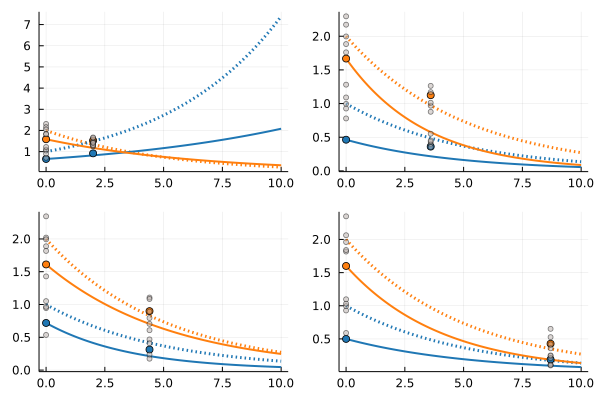

24.447155681724666


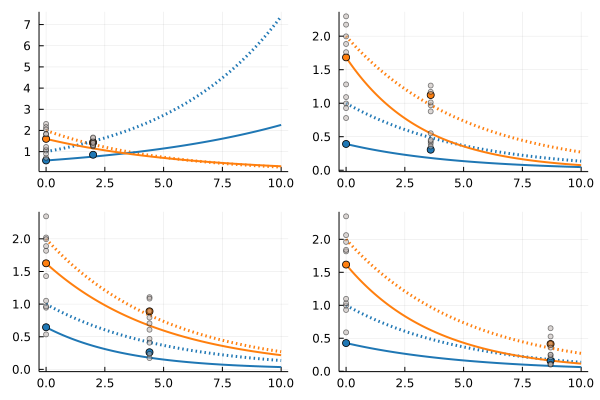

mean(L.(xs, x_baseline, tvals)) = 22.654413116304077
mean(L.(xs, x_baseline, tvals)) = 

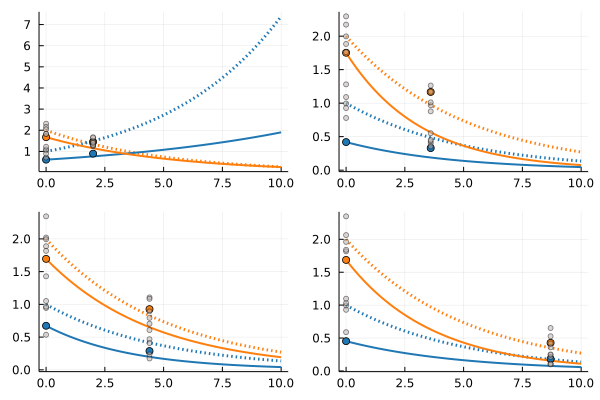

21.942078465119163


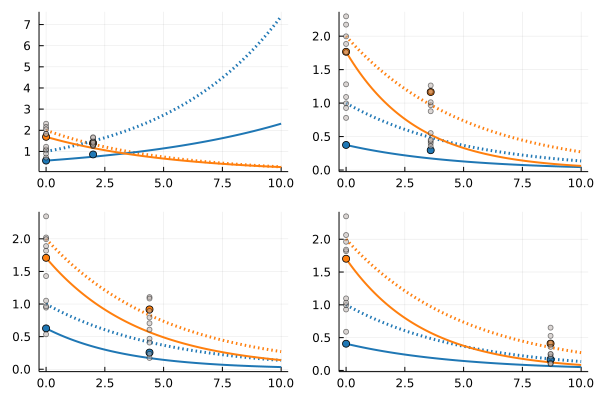

mean(L.(xs, x_baseline, tvals)) = 19.989186281318492
mean(L.(xs, x_baseline, tvals)) = 

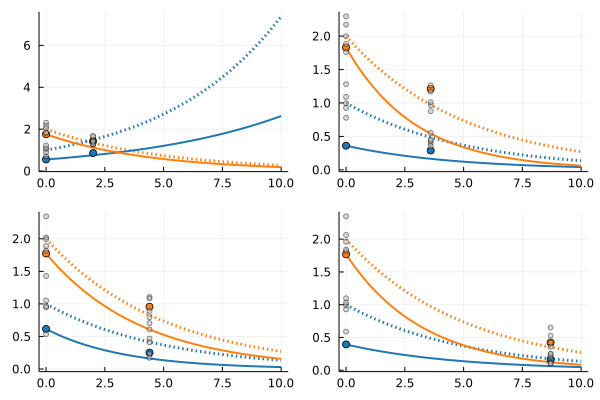

19.068366178607118


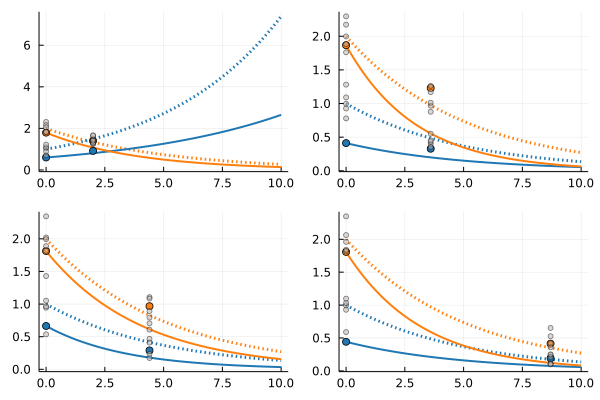

mean(L.(xs, x_baseline, tvals)) = 18.065743478948594
mean(L.(xs, x_baseline, tvals)) = 

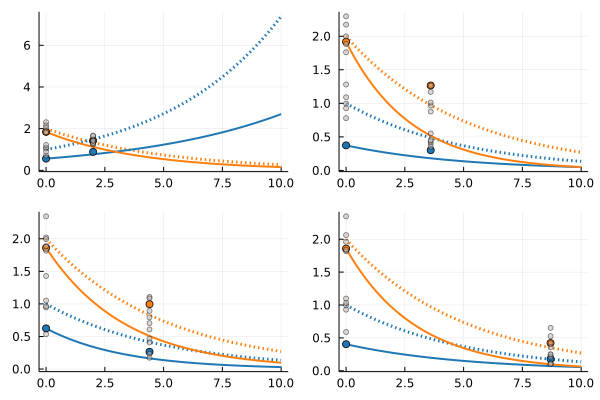

16.76472866470439


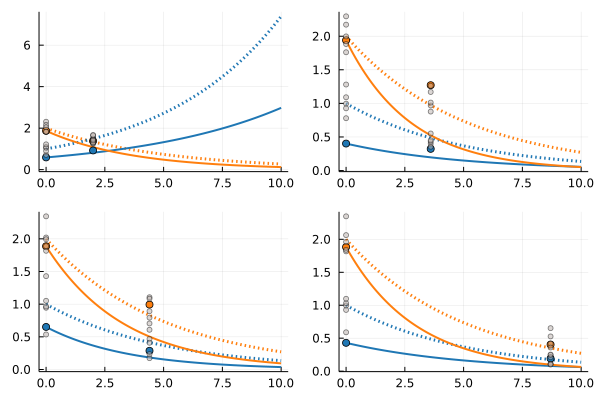

mean(L.(xs, x_baseline, tvals)) = 16.12808286696918
mean(L.(xs, x_baseline, tvals)) = 

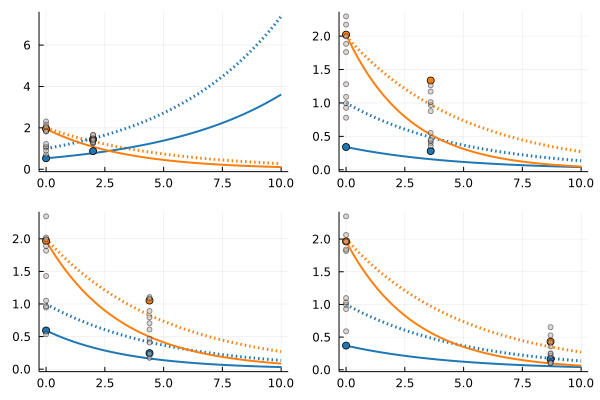

15.993467647080763


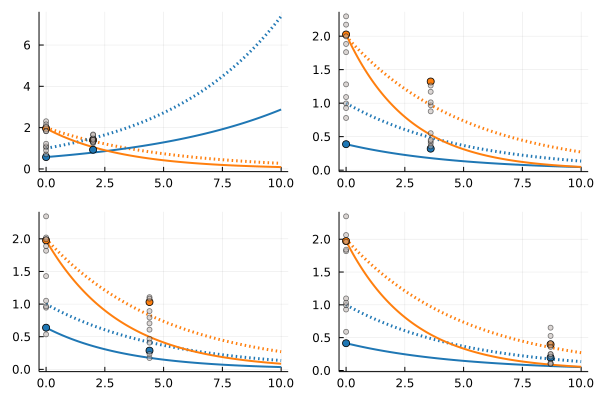

mean(L.(xs, x_baseline, tvals)) = 13.826227137151331
mean(L.(xs, x_baseline, tvals)) = 

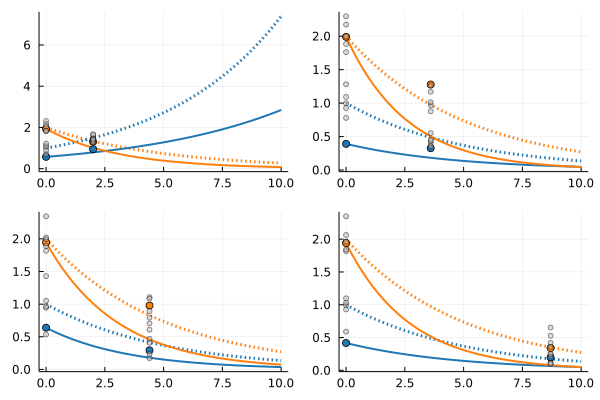

13.773832381993934


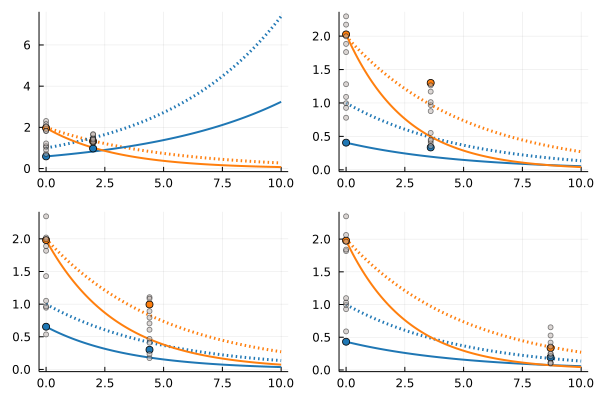

mean(L.(xs, x_baseline, tvals)) = 13.099898254311457


In [10]:
for epoch in 1:35
    Flux.train!(L, ps, trainingdata, opt)
    evalcb()
    evalcb_zs()
end

## Visualize results 

Finally, we can look at the results to evaluate what our model has learnt. 

We plot two individual solutions, one from each group, as well as the solutions across all individuals in each group. This reproduces the four panels of Figure 4. 

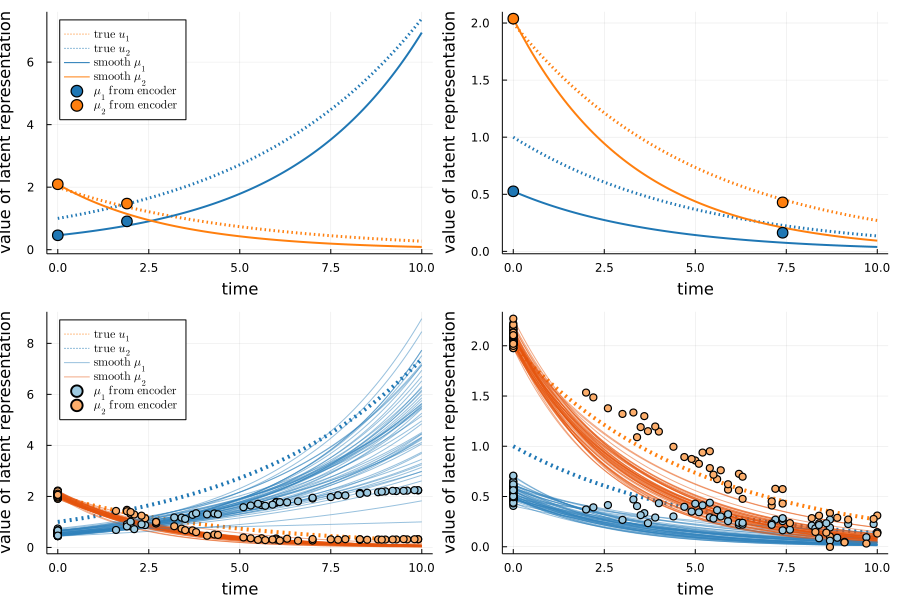

In [11]:
# individual plots 
p1 = plot_individual_solutions(20,xs, x_baseline, tvals, group1, sol_group1, sol_group2, m, dt, 
                                swapcolorcoding=true, showlegend=true)
p2 = plot_individual_solutions(28,xs, x_baseline, tvals, group1, sol_group1, sol_group2, m, dt, 
                                swapcolorcoding=true, showlegend=false)
# solutions across the dataset
p3 = allindsplot(2, data, m, sol_group1, sol_group2, swapcolorcoding=true)
p4 = allindsplot(1, data, m, sol_group1, sol_group2, swapcolorcoding=true, showlegend=false)

display(plot(p1, p2, p3, p4, layout=(2,2), size=(900,600)))

Additionally, we can save the figures in the `figures` subfolder. 

In [12]:
# save results 
savefig(p1, "../figures/Figure4_topleft.pdf")
savefig(p2, "../figures/Figure4_topright.pdf")
savefig(p3, "../figures/Figure4_bottomleft.pdf")
savefig(p4, "../figures/Figure4_bottomright.pdf")